## Problem setup with finite differences

The heat equation is written as follows:

$$
(1)\:\:\:\frac{\partial\phi}{\partial t}-\alpha\frac{\partial^{2}\phi}{\partial x^{2}}=0,
$$

where $\alpha$ is the thermal diffusivity, which we will consider to be $\alpha=\frac{1}{\pi^{2}}$. The initial condition will be considered as follows:

$$
\phi(x,0)=\alpha\:\text{sin}\left(\frac{x}{\sqrt{\alpha}}\right),
$$

and the boundary conditions:

$$
\phi(a,t)=\phi(b,t)=0,
$$

with the following initial condition for the first derivative with respect to the time:

$$
\partial_{t}\phi(x,0)=-\alpha\:\text{sin}\left(\frac{x}{\sqrt{\alpha}}\right).
$$

With this, the problem will be solved for:

$$
\Omega=[0,1],\:\:\:\:0\leq t\leq 1.
$$

The analytical solution is known so we can compare:

$$
\phi(x,t)=\alpha\:e^{-t}\text{sin}\left(\frac{x}{\sqrt{\alpha}}\right).
$$

Using the method of finite differences with the forward scheme for the temporal first order derivative in order to discretize (1), we get:

$$
\phi_{j}^{n+1}=\frac{\alpha\Delta t}{\Delta x^{2}}\left(\phi_{j+1}^{n}-2\phi_{j}^{n}+\phi_{j-1}^{n}\right)+\phi_{j}^{n}
$$

In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import math

# Set data type:
DTYPE = "float32"
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = np.pi
alpha = 1/(pi**2)

# Discretization:
t_i, t_f, x_i, x_f = 0., 1., 0., 1.
nx, nt = 100, 5000
delta_x, delta_t = (x_f - x_i)/nx, (t_f - t_i)/nt
lam = delta_t/delta_x

x = np.linspace(x_i, x_f, nx)
t = np.linspace(t_i, t_f, nt)

# Initial conditions:
ic_phi_f = lambda x: alpha * tf.sin(tf.constant(x/math.sqrt(alpha), dtype = DTYPE))

ic_phi = tf.constant(ic_phi_f(x), dtype = DTYPE)

print(lam)

2022-03-12 13:11:12.031359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


0.02


2022-03-12 13:11:12.056834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 13:11:12.056984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 13:11:12.057912: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-12 13:11:12.058821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [2]:
phi_n = ic_phi
phi_evolved = []

for t in tqdm(range(0, nt)):
    phi_j_list = []
    for j in range(0, nx):
        if (j != 0) and (j != nx-1):
            phi_n_p1 = (alpha*delta_t/(delta_x**2)) * (phi_n[j+1] - 2*phi_n[j] + phi_n[j-1]) + phi_n[j]
            
            phi_j_list.append(float(phi_n_p1))
        else:
            phi_j_list.append(0.)

    # After getting out of the spatial bucle, we need to update the values of phi in that "j" so the next iteration over time takes it into account.
    phi_n = tf.constant(np.array(phi_j_list), dtype = DTYPE)
    phi_n = tf.reshape(phi_n, shape = (phi_n.shape[0], 1))
    
    phi_evolved.append(np.array(phi_j_list))

phi_evolved = np.stack(phi_evolved, axis = 0)

100%|███████████████████████████████████████| 5000/5000 [06:59<00:00, 11.91it/s]


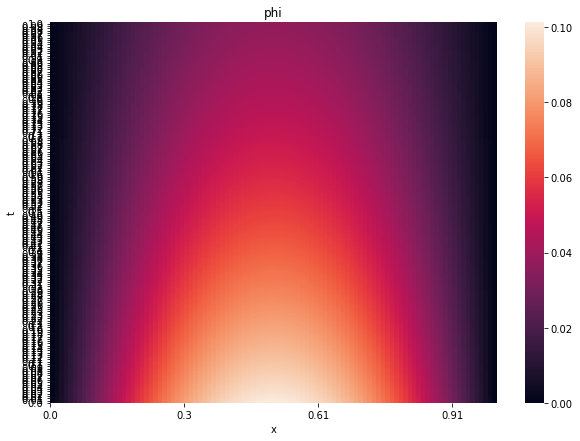

In [3]:
# Plot 2D heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Set up meshgrid
tspace = np.linspace(t_i, t_f, nt)
xspace = np.linspace(x_i, x_f, nx)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Plot 2D heatmap
plt.figure(figsize = (10, 7))
ax = sns.heatmap(phi_evolved)
ax.set_xticks(range(0, xspace.shape[0], 30))
ax.set_xticklabels([np.round(xspace[i], 2) for i in list(range(0, xspace.shape[0], 30))])
ax.set_yticks(range(0, tspace.shape[0], 30))
ax.set_yticklabels([np.round(tspace[i], 2) for i in list(range(0, tspace.shape[0], 30))])
plt.xlabel("x")
plt.ylabel("t")
plt.title("phi")
ax.invert_yaxis()
plt.savefig("Images/phi_Heatmap_numeric.png")
plt.show()

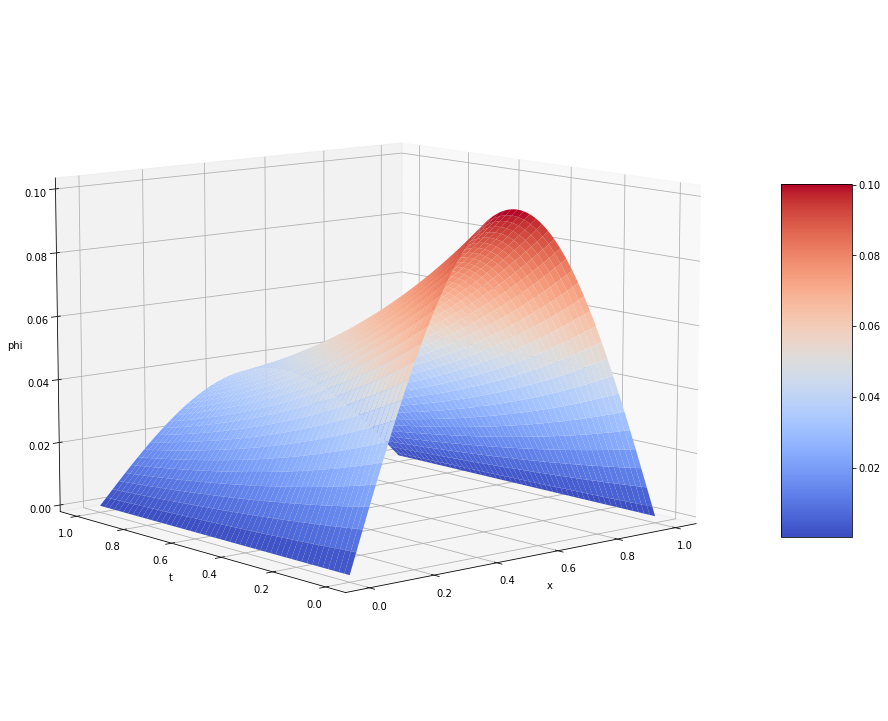

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(x_i, x_f, nx)
t = np.linspace(t_i, t_f, nt)

X, T = np.meshgrid(x, t)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(22, 13)
surf = ax.plot_surface(X, T, phi_evolved, cmap = cm.coolwarm, linewidth = 0, antialiased = True)
ax.view_init(elev = 10, azim = 230)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("phi")
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.savefig("Images/phi_3D_numeric.png")
plt.show()

## Setup of the problem with a PINN.

Now, we are going to solve the problem using a neural network so we can check the result.

In [5]:
# Import TensorFlow and NumPy
import os
import tensorflow as tf
import numpy as np

print("Is Tensorflow using GPU? ", tf.test.is_gpu_available())
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

# Set data type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = np.pi
alpha = 1/(pi**2)

# Define initial condition
def fun_u_0(x):
    x_numpy = x.numpy()
    lambda x: alpha * tf.sin(tf.constant(x/math.sqrt(alpha), dtype = DTYPE))
    
    return tf.constant(ic_phi_f(x_numpy), dtype = DTYPE)

# Define the boundary conditions
def fun_u_b(t, x):
    return tf.zeros(shape = (x.shape[0], 1), dtype = DTYPE)

# Define residual of the PDE
def fun_r(t, x, phi_t, phi_xx):
    return phi_t - alpha*phi_xx

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is Tensorflow using GPU?  True


2022-03-12 13:19:24.735138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 13:19:24.735344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 13:19:24.735453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 13:19:24.735605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 13:19:24.735722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [6]:
# Set number of data points
N_0, N_b, N_r = 5000, 5000, 20000

# Set boundary
tmin, tmax, xmin, xmax = 0., 1., 0., 1.

# Lower bounds and upper bounds
lb, ub = tf.constant([tmin, xmin], dtype = DTYPE), tf.constant([tmax, xmax], dtype = DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype = DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype = DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype = DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype = DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

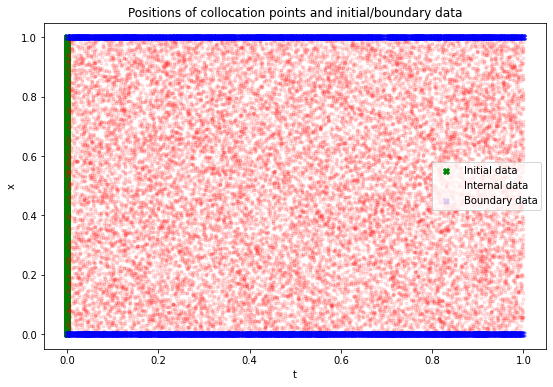

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c = "g", marker = "X", vmin = -1, vmax = 1, label = "Initial data")
plt.scatter(t_r, x_r, c = "r", marker = ".", alpha = 0.1, label = "Internal data")
plt.scatter(t_b, x_b, c = "b", marker = "X", alpha = 0.1, label = "Boundary data")
plt.legend()
plt.xlabel("t")
plt.ylabel("x")

plt.title('Positions of collocation points and initial/boundary data')
plt.show()

In [8]:
def init_model(num_hidden_layers = 8, num_neurons_per_layer = 30):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1, activation=tf.keras.activations.get('tanh')))
    
    return model

In [9]:
def get_r(model, X_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        tape.watch(t)
        tape.watch(x)

        # Determine residual 
        phi = model(tf.stack([t[:,0], x[:,0]], axis=1))

        phi_x = tape.gradient(phi, x)
        
    phi_t = tape.gradient(phi, t)
    phi_xx = tape.gradient(phi_x, x)

    del tape

    return fun_r(t, x, phi_t, phi_xx)

In [10]:
def compute_loss(model, X_r, X_data, u_data):
    
    # Compute loss_r
    r = get_r(model, X_r)
    loss_r = tf.reduce_mean(tf.square(r))
    
    u_pred_ic = model(X_data[0])
    u_pred_bc = model(X_data[1])
    
    loss_ic = tf.reduce_mean(tf.square(u_data[0] - u_pred_ic))
    loss_bc = tf.reduce_mean(tf.square(u_data[1] - u_pred_bc))
    
    loss = 10*loss_r + 0.01*loss_ic + 0.1*loss_bc
    
    return loss, loss_ic, loss_r, loss_bc

In [11]:
def get_grad(model, X_r, X_data, u_data):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss, loss_ic, loss_r, loss_bc = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g, loss_ic, loss_r, loss_bc

In [12]:
# Create batches from data:
batch_size = 2000

X_r_batches = tf.data.Dataset.from_tensor_slices(X_r.numpy()).batch(batch_size)

In [13]:
# Initialize model aka u_\theta
model = init_model()

lr = 0.001
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate = lr)

In [14]:
# Number of training epochs
epochs = 2500
loss_hist, loss_ic_hist, loss_r_hist = [], [], []

for epoch in range(epochs):
    for step, X_r_batch in enumerate(X_r_batches):
        loss, grad_theta, loss_ic, loss_r, loss_bc = get_grad(model, X_r_batch, X_data, u_data)
        optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    loss_hist.append(loss.numpy())
    loss_ic_hist.append(loss_ic.numpy())
    loss_r_hist.append(loss_r.numpy())
    if epoch%10 == 0:
        print("Epoch ", str(epoch), ": Total Loss = ", str(float(loss)), ", Loss IC = ", str(float(loss_ic)), ", Loss BC = ", str(float(loss_bc)), ", Loss R = ", str(float(loss_r)))

Epoch  0 : Total Loss =  0.3636125922203064 , Loss IC =  0.0074353874661028385 , Loss BC =  0.03270629048347473 , Loss R =  0.036026760935783386
Epoch  10 : Total Loss =  0.0004569925949908793 , Loss IC =  0.005762680433690548 , Loss BC =  0.00043255413766019046 , Loss R =  3.561103585525416e-05
Epoch  20 : Total Loss =  0.0001798399753170088 , Loss IC =  0.0047205728478729725 , Loss BC =  0.0001124087066273205 , Loss R =  1.2139337741245981e-05
Epoch  30 : Total Loss =  0.00011192257807124406 , Loss IC =  0.0046082064509391785 , Loss BC =  3.923352778656408e-05 , Loss R =  6.1917157836433034e-06
Epoch  40 : Total Loss =  9.0184279542882e-05 , Loss IC =  0.004570562392473221 , Loss BC =  4.145712955505587e-05 , Loss R =  4.033294771943474e-06
Epoch  50 : Total Loss =  8.02834692876786e-05 , Loss IC =  0.004548829048871994 , Loss BC =  4.379007805255242e-05 , Loss R =  3.0416176741709933e-06
Epoch  60 : Total Loss =  7.409647514577955e-05 , Loss IC =  0.004530784208327532 , Loss BC =  4

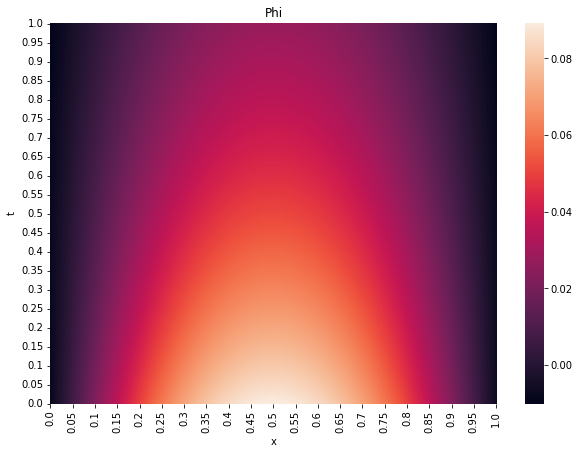

In [15]:
# Plot 2D heatmap
import seaborn as sns

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
phi = model(tf.cast(Xgrid, DTYPE))

# Reshape upred
phi = phi.numpy().reshape(N+1,N+1).T

# Plot 2D heatmap
plt.figure(figsize = (10, 7))
ax = sns.heatmap(phi)
ax.set_xticks(range(0, xspace.shape[0], 30))
ax.set_xticklabels([np.round(xspace[i], 2) for i in list(range(0, xspace.shape[0], 30))])
ax.set_yticks(range(0, tspace.shape[0], 30))
ax.set_yticklabels([np.round(tspace[i], 2) for i in list(range(0, tspace.shape[0], 30))])
plt.xlabel("x")
plt.ylabel("t")
plt.title("Phi")
ax.invert_yaxis()
plt.savefig("Images/HeatEquation_1D_Eq_Heatmap.png")
plt.show()

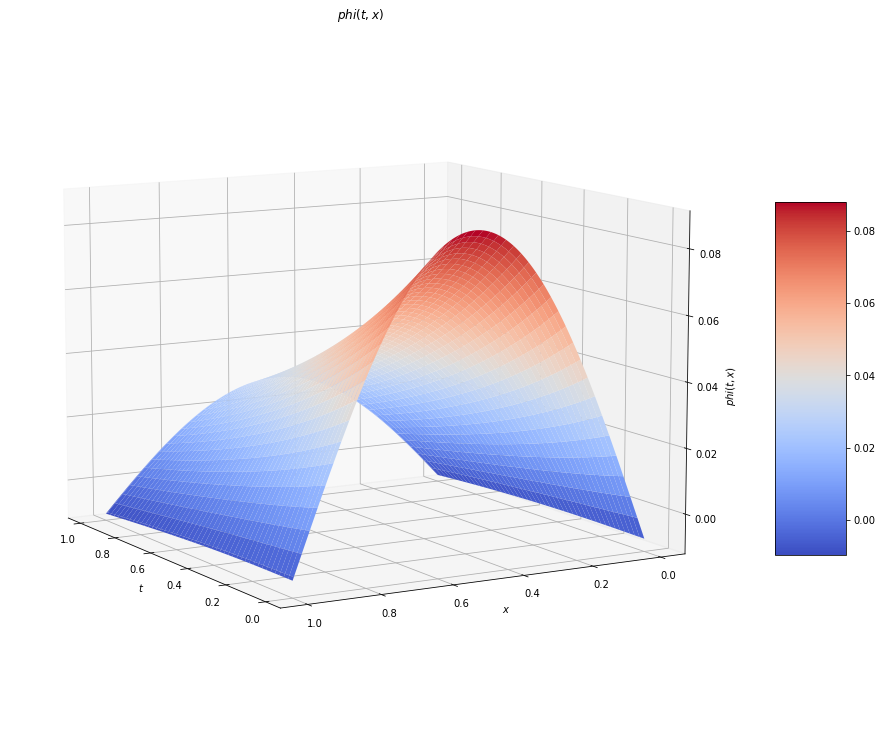

In [16]:
# Plot 3D surface
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(22, 13)
surf = ax.plot_surface(X, T, phi, cmap = cm.coolwarm, linewidth = 0, antialiased = True)
ax.view_init(elev = 10, azim = 150)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$phi(t,x)$')
ax.set_title('$phi(t,x)$')
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.savefig("Images/HeatEquation_1D_Eq_3D.png")
plt.show()